# XGBoost model

In [67]:
import pandas as pd
import numpy as np
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['figure.figsize'] = [20.0,8.0]
plt.rcParams['figure.dpi']=80

import modify_dataset as md

In [2]:
#Common error function to minimize: Root Mean Square Percentage Error
#We will have to integrate our loss function with xgboost

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [3]:
df = pd.read_csv("dataset/enriched_train.csv")

In [4]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['D_Day_of_week'] = df['Date'].dt.dayofweek

In [7]:
df = df.drop(['NumberOfCustomers','IsOpen','Date','StoreID'], axis=1)
#df = df.drop(['Region','Events'], axis=1)
# I could leave events

In [8]:
#for now let's drop unusable categorical vars
df = df.drop(['StoreType','AssortmentType','Events'], axis=1)

In [9]:
df.head().T

,0,1,2,3,4
IsHoliday,0.000000,0.000000,0.000000,0.000000,0.000000
HasPromotions,1.000000,1.000000,1.000000,0.000000,0.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,7109.000000,8041.000000,7890.000000,6005.000000,7675.446488
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
CloudCover,6.000000,6.000000,5.000000,7.000000,8.000000
Max_Dew_PointC,6.000000,0.000000,-1.000000,-5.000000,-10.000000


In [10]:
df.shape

(523000, 46)

In [11]:
train = md.get_fake_train(df)

In [12]:
train.shape

(479184, 46)

In [13]:
test = md.get_fake_test(df)
test.shape

(43816, 46)

In [14]:
#print("Load the training, test and store data using pandas")
#train = pd.read_csv("train.csv",low_memory=False)
#test = pd.read_csv("test.csv")
#store = pd.read_csv("store.csv")

### Selecting predictive features 

In [15]:
features = list(train.columns.values)
features.remove('NumberOfSales')
print("features")

print(features)

features
['IsHoliday', 'HasPromotions', 'NearestCompetitor', 'Region', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'CloudCover', 'Max_Dew_PointC', 'Max_Humidity', 'Max_Sea_Level_PressurehPa', 'Max_TemperatureC', 'Max_VisibilityKm', 'Max_Wind_SpeedKm_h', 'Mean_Dew_PointC', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa', 'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h', 'Min_Dew_PointC', 'Min_Humidity', 'Min_Sea_Level_PressurehPa', 'Min_TemperatureC', 'Min_VisibilitykM', 'Precipitationmm', 'WindDirDegrees', 'D_Day', 'D_DayOfYear', 'D_Month', 'D_Year', 't-14', 't-7', 't-1', 't-2', 't-9', 't-8', 't-6', 't-15', 't-21', 't-13', 't-20', 'MeanStoreSales', 'MeanRegionSales', 'D_Day_of_week']


In [16]:
params = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 8,
          "subsample": 1.0,
          "colsample_bytree": 0.3,
          "silent": 1,
          "nthread":-1
          }
num_trees = 100 #400

In [17]:
#split in train and test (not real test which is called test and is the fake test provided by md)
X_train, X_test = train_test_split(train, test_size=0.1)
#X_train, X_test = train.head(len(train) - val_size), train.tail(val_size)

In [18]:
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["NumberOfSales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["NumberOfSales"] + 1))
#dtest = xgb.DMatrix(test[features])

In [19]:
X_train.shape

(431265, 46)

In [20]:
X_test.shape

(47919, 46)

In [21]:
watchlist = [(dvalid, 'test'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=20, feval=rmspe_xg, verbose_eval=True)

[0]	test-rmse:6.33679	train-rmse:6.33711	test-rmspe:0.998285	train-rmspe:0.998306
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 20 rounds.
[1]	test-rmse:5.07178	train-rmse:5.07181	test-rmspe:0.993531	train-rmspe:0.993551
[2]	test-rmse:4.05949	train-rmse:4.05948	test-rmspe:0.982071	train-rmspe:0.982094
[3]	test-rmse:3.24957	train-rmse:3.24946	test-rmspe:0.959865	train-rmspe:0.959895
[4]	test-rmse:2.60204	train-rmse:2.60175	test-rmspe:0.923645	train-rmspe:0.923699
[5]	test-rmse:2.08447	train-rmse:2.08381	test-rmspe:0.872373	train-rmspe:0.872461
[6]	test-rmse:1.67088	train-rmse:1.66989	test-rmspe:0.807558	train-rmspe:0.80774
[7]	test-rmse:1.34136	train-rmse:1.33997	test-rmspe:0.732654	train-rmspe:0.733018
[8]	test-rmse:1.07745	train-rmse:1.07558	test-rmspe:0.652778	train-rmspe:0.653531
[9]	test-rmse:0.867489	train-rmse:0.865107	test-rmspe:0.572224	train-rmspe:0.573547
[10]	test-rmse:0.700604	train-rm

### Validating

In [23]:
print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

Validating
error 0.10819549936534462


RMSE

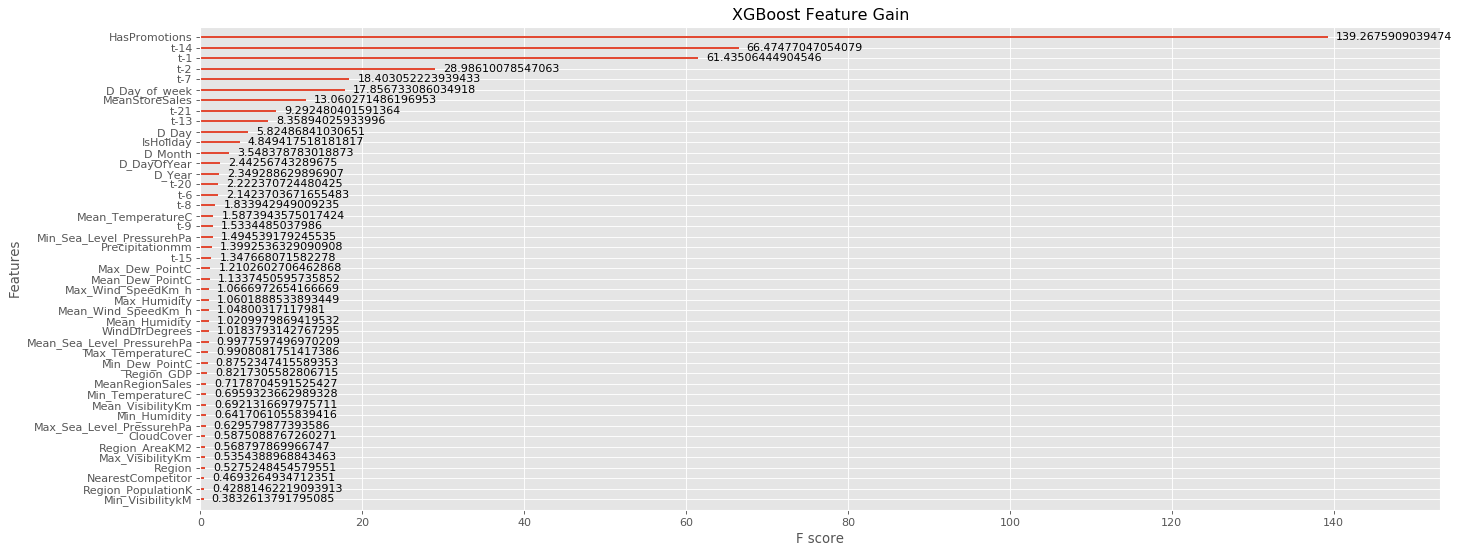

In [27]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="gain")
plt.title("XGBoost Feature Gain")
plt.show()

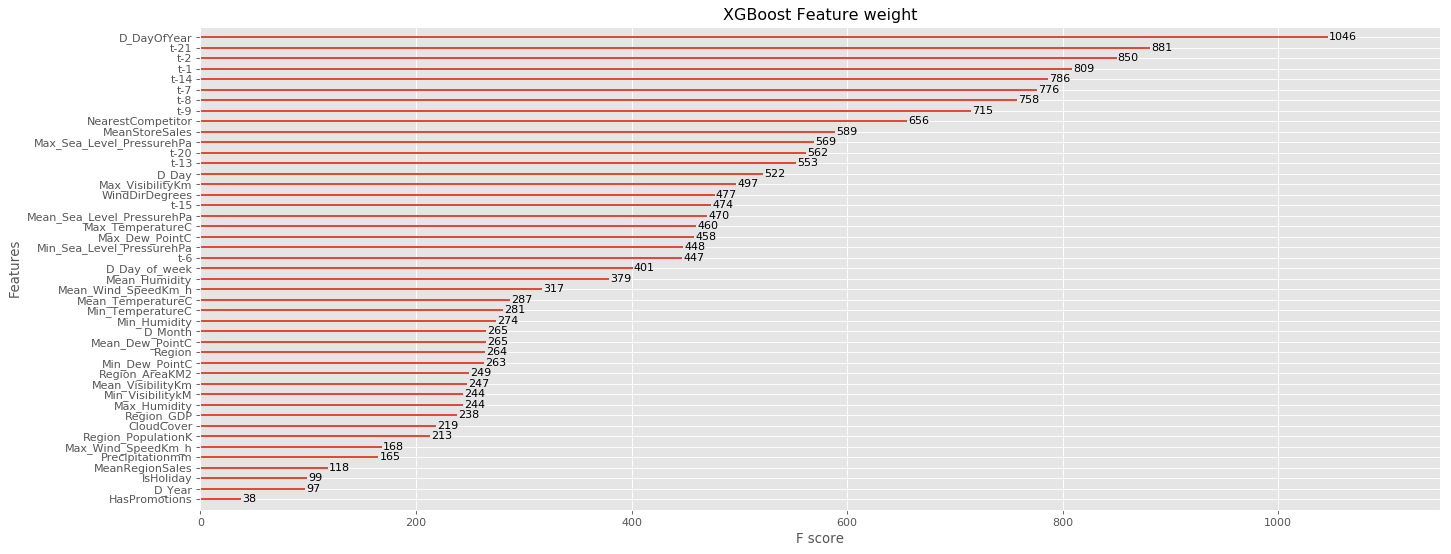

In [28]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="weight")
plt.title("XGBoost Feature weight")
plt.show()

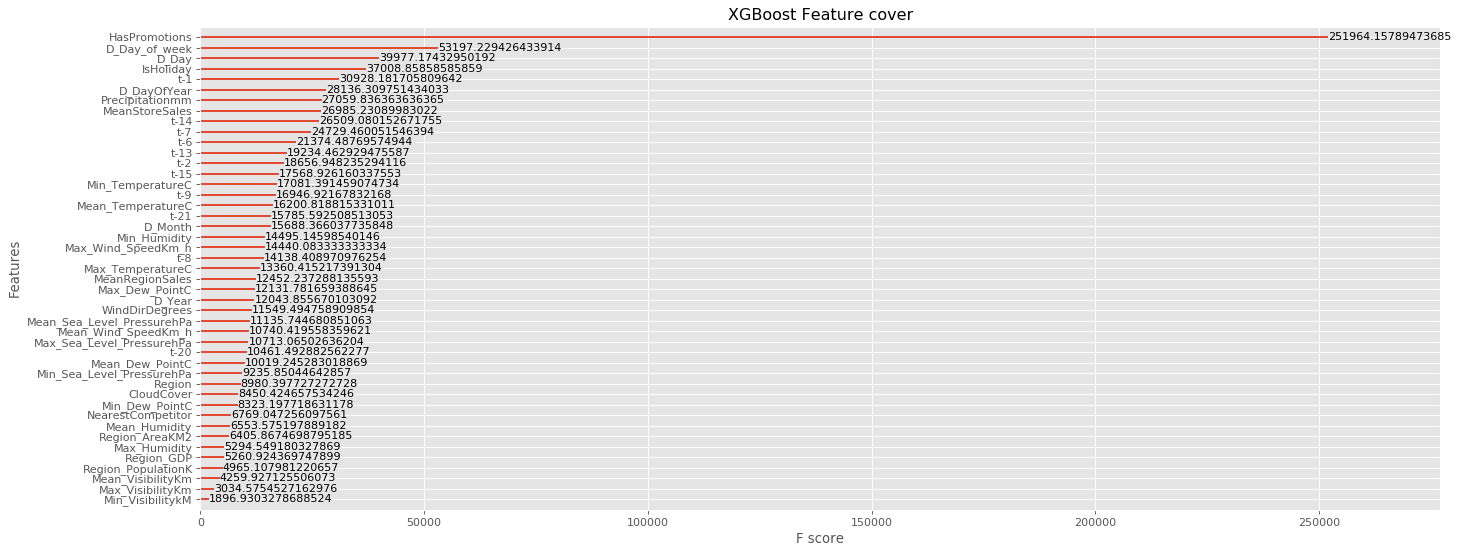

In [29]:
# # Feature importance XGB for all features 
from xgboost import plot_importance
plot_importance(gbm, importance_type="cover")
plt.title("XGBoost Feature cover")
plt.show()

### Predict on fake test set

In [30]:
train_probs = gbm.predict(xgb.DMatrix(test[features]))

In [53]:
test['pred'] = np.exp(gbm.predict(xgb.DMatrix(test[features])))-1

In [54]:
train_probs.shape

(43816,)

In [43]:
#test['predicted'] = pd.Series([train_probs], index=test.index)
#test['predicted']=train_probs

In [55]:
test.head().T

,649,650,651,652,653
IsHoliday,0.000000,0.000000,0.000000,1.000000,0.000000
HasPromotions,0.000000,0.000000,0.000000,0.000000,0.000000
NearestCompetitor,326.000000,326.000000,326.000000,326.000000,326.000000
Region,7.000000,7.000000,7.000000,7.000000,7.000000
NumberOfSales,8540.000000,10364.000000,4676.000000,7675.446488,6267.000000
Region_AreaKM2,9643.000000,9643.000000,9643.000000,9643.000000,9643.000000
Region_GDP,17130.000000,17130.000000,17130.000000,17130.000000,17130.000000
Region_PopulationK,2770.000000,2770.000000,2770.000000,2770.000000,2770.000000
CloudCover,6.000000,7.000000,7.000000,7.000000,6.000000
Max_Dew_PointC,0.000000,1.000000,2.000000,2.000000,3.000000


In [56]:
compare = test[['NumberOfSales','pred']]

In [57]:
test.to_csv('./dataset/XGB1_fake_test.csv', index=False)

In [59]:
error = rmspe(test['pred'].values, test['NumberOfSales'].values)
print('error', error)

error 0.18742093958897296


In [58]:
compare[1000:1100]

,NumberOfSales,pred
12677,3132.452736,2987.991455
12678,3379.000000,3043.893311
12679,1867.000000,2211.727295
12680,3132.452736,3298.197998
12681,5269.000000,4554.859863
12682,4045.000000,4799.891113
12683,3191.000000,4302.178711
12684,3500.000000,3131.633301
12685,3379.000000,3657.879395
12686,1890.000000,2095.255127


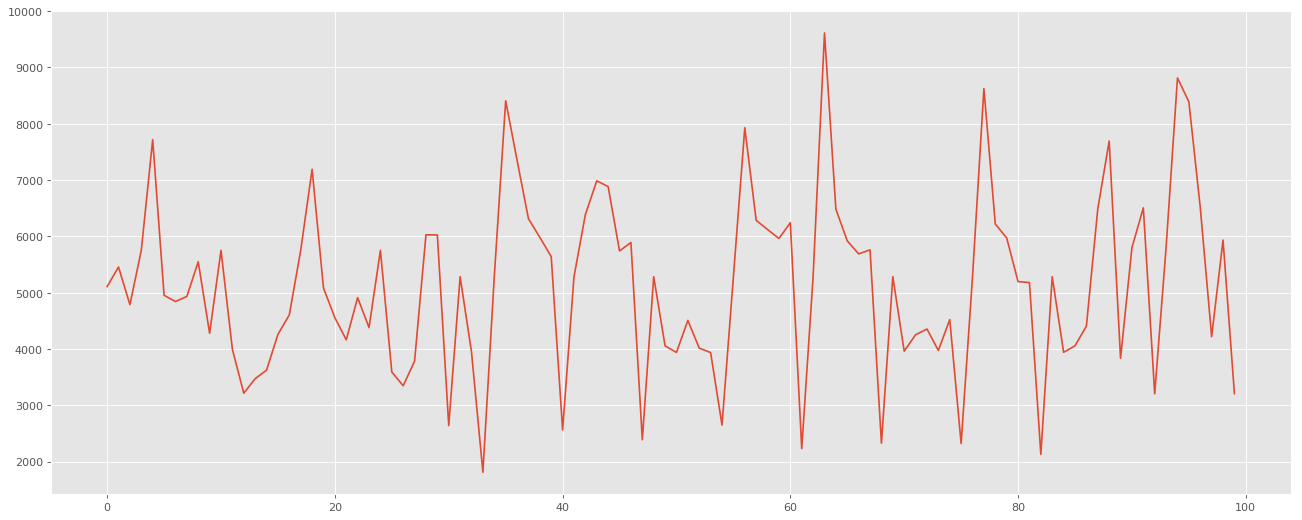

In [75]:
start = 500
end = 600
import matplotlib.pyplot as plt

y = compare.iloc[start:end,0].values
x_coordinate = [ 1 * i for i in range(len(y)) ]
plt.plot(x_coordinate,y)
plt.show()

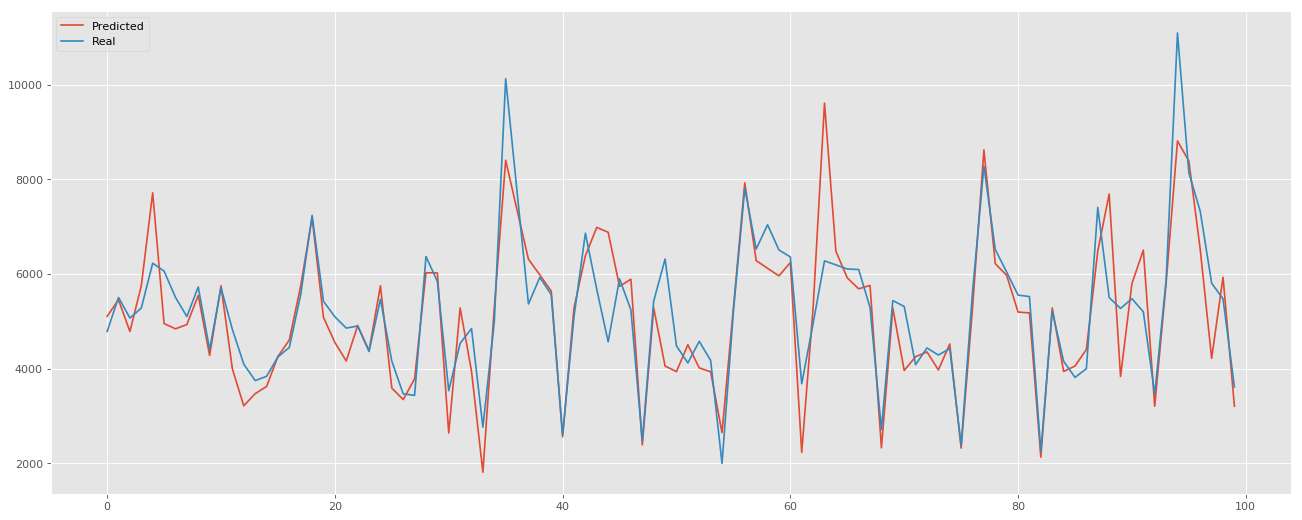

In [78]:
import matplotlib.pyplot as plt

yhat = compare.iloc[start:end:1].values
x_coordinate = [ 1 * i for i in range(len(yhat)) ]
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

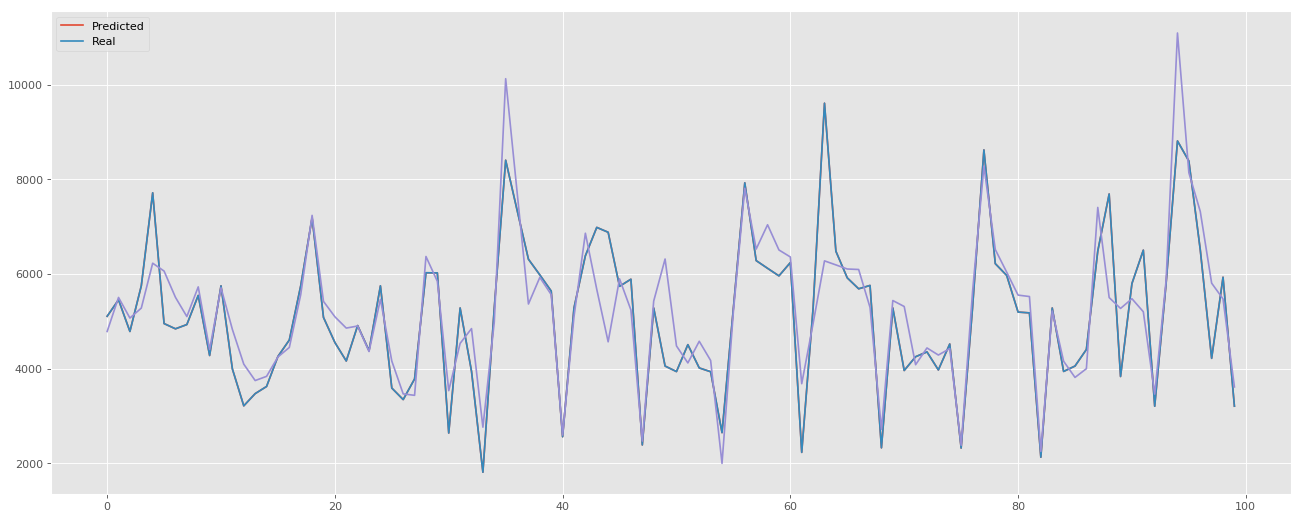

In [77]:
import matplotlib.pyplot as plt
#import matplotlib as mpl

#mpl.style.use("default")


plt.plot(x_coordinate,y)
plt.plot(x_coordinate,yhat)
plt.legend(['Predicted', 'Real'], loc='upper left')
plt.show()

In [ ]:
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['NumberOfSales'].values)
print('error', error)

In [26]:
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

Make predictions on the test set


In [56]:
Y = df.iloc[:, 3]

In [57]:
Y

0          7109.0
1          8041.0
2          7890.0
3          6005.0
4          8550.0
5          8589.0
6          9055.0
7         11907.0
8         11129.0
9          6981.0
10         5222.0
11         6509.0
12         6270.0
13         6790.0
14         9185.0
15         8948.0
16         7995.0
17         7515.0
18         8010.0
19         6628.0
20         6315.0
21         6290.0
22         5899.0
23         6296.0
24         6327.0
25         6343.0
26         8430.0
27         8426.0
28         7356.0
29         7067.0
           ...   
409207     3277.0
409208     2958.0
409209     2206.0
409210     4744.0
409211     5547.0
409212     4095.0
409213     4668.0
409214     5384.0
409215     2976.0
409216     6173.0
409217     5239.0
409218     4417.0
409219     4932.0
409220     4991.0
409221     2203.0
409222     3480.0
409223     3765.0
409224     3314.0
409225     3786.0
409226     3622.0
409227     2461.0
409228     4930.0
409229     5089.0
409230     4627.0
409231    